# Estudo de caso sobre bicicletas alugadas em Seul - Coreia do Sul

Os dados foram coletados durante os anos de 2017 e 2018. Consistem em informações sobre o clima e data. O objetivo é prever a quantidade de bicicletas que serão alugadas nas condições propostas.

Os dados podem ser obtidos em: <https://archive.ics.uci.edu/ml/datasets/Seoul+Bike+Sharing+Demand>

---

**Citações**

[1] Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

[2] Sathishkumar V E, Jangwoo Park, and Yongyun Cho. 'Using data mining techniques for bike sharing demand prediction in metropolitan city.' Computer Communications, Vol.153, pp.353-366, March, 2020

[3] Sathishkumar V E and Yongyun Cho. 'A rule-based model for Seoul Bike sharing demand prediction using weather data' European Journal of Remote Sensing, pp. 1-18, Feb, 2020


## Resumo
* Importando as principais bibliotecas
* Importando o conjunto de dados
* Análise Exploratória
* Criação de Variáveis
* Pré-processamento de dados
* Divisão dos dados entre treino e teste
* Modelo (XGBoost)
* Predição nos dados de treino
* Predição nos dados de teste
* Performance do modelo nos dados de teste
* Impacto das variáveis no modelo
* Realizando uma predição

## Importando as principais bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set_theme(style="darkgrid")

## Importando o conjunto de dados

In [ ]:
dataset = pd.read_csv(
    'https://archive.ics.uci.edu/ml/machine-learning-databases/00560/SeoulBikeData.csv', 
    encoding='ISO-8859-1')

In [ ]:
dataset.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


## Análise Exploratória

### Há valores nulos?

In [ ]:
dataset.isnull().sum()

Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64

### Resumo dos dados

In [ ]:
dataset.describe()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


### Histogramas das variáveis numéricas

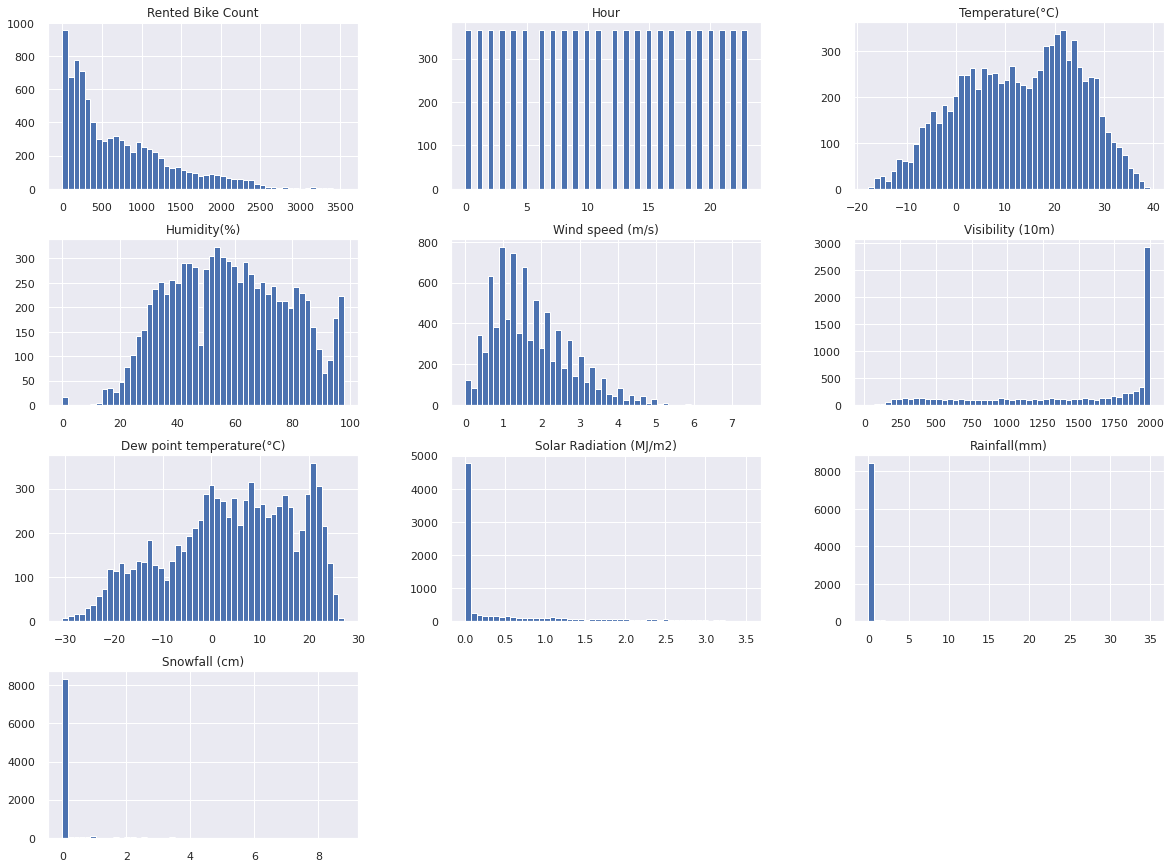

In [ ]:
dataset.hist(bins=50, figsize=(20,15))
plt.show()

### Correlações das variáveis numéricas

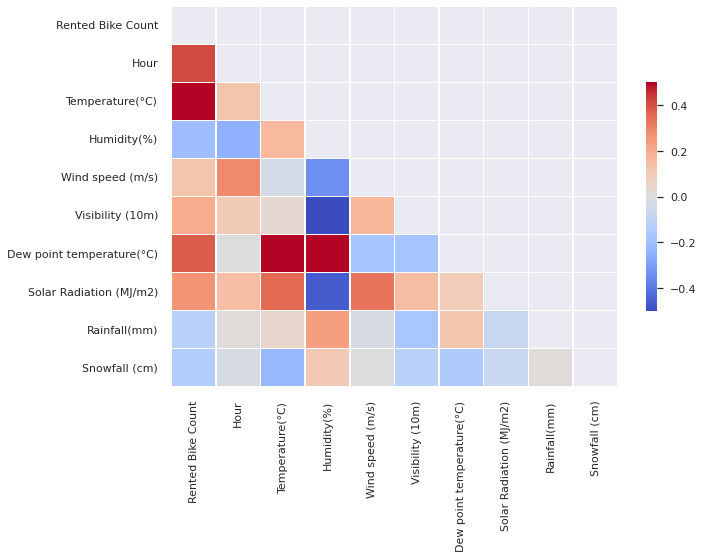

In [ ]:
dt_corr = dataset.corr()
dt_mask = np.zeros_like(dt_corr, dtype=np.bool)
dt_mask[np.triu_indices_from(dt_mask)] = True
fig, ax = plt.subplots(figsize=(10, 7))
pl = sns.heatmap(dt_corr, mask=dt_mask, cmap= "coolwarm", vmax=.5, vmin=-.5, center=0, linewidths=.5,
                 cbar_kws={"shrink": 0.6})
plt.show()

Alta correlação entre a quantidade de bicicletas alugadas e a temperatura. Pouca correlação entre precipitação e neve com as demais variáveis.


### Bicicletas alugadas por hora

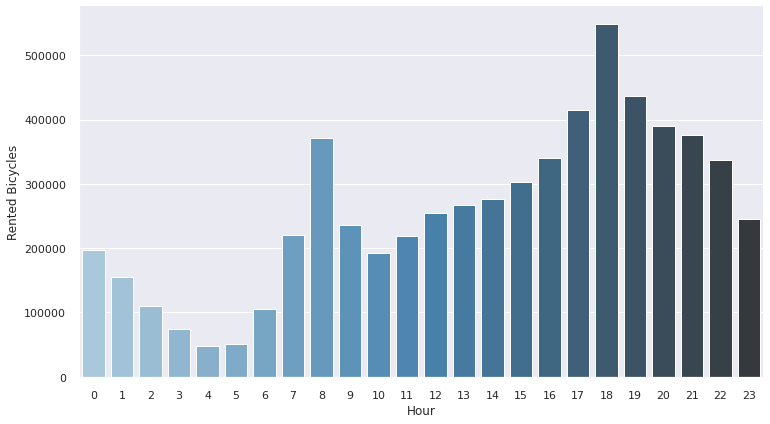

In [ ]:
hour = pd.DataFrame({'Hour': [i for i in range(24)], 
                     'Rented Bicycles': dataset.groupby('Hour').sum()['Rented Bike Count']})

sns.catplot(x='Hour', y='Rented Bicycles', kind='bar', data=hour, height=6, aspect=1.8, 
    palette='Blues_d', ci=None)

Há picos às 8h e 18h. Uma causa provável é o início e fim do horário comercial, em que muitas pessoas utilizam bicicletas para se locomover até o trabalho.

### Bicicletas alugadas por temperatura

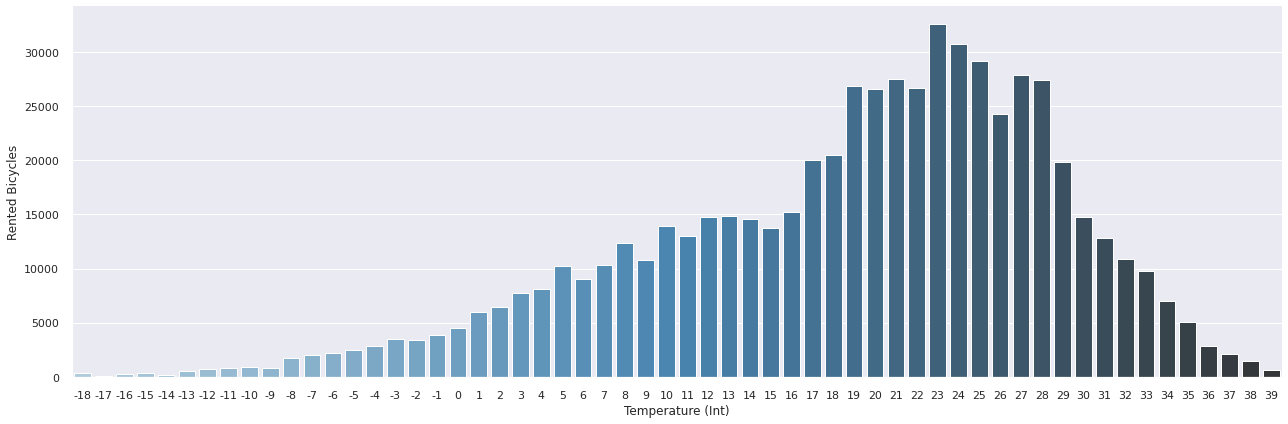

In [ ]:
temperature = pd.DataFrame({'Temperature': dataset.groupby('Temperature(°C)').sum()['Rented Bike Count'].index, 
                            'Rented Bicycles': dataset.groupby('Temperature(°C)').sum()['Rented Bike Count'].values})

temperature['Temperature (Int)'] = temperature.Temperature.map(lambda t: round(t))

sns.catplot(x='Temperature (Int)', y='Rented Bicycles', kind='bar', data=temperature, height=6, aspect=3, 
    palette='Blues_d', ci=None)

Entre os 19 °C e 28 °C está a maior parte dos aluguéis, sendo realmente a faixa de temperatura mais agradável para a prática de atividades ao ar livre.

### Bicicletas alugadas por estação

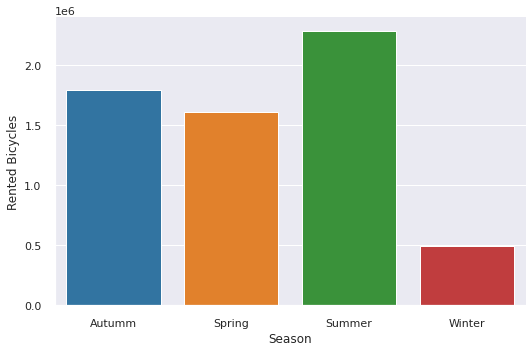

In [ ]:
labels = ['Autumm', 'Spring', 'Summer', 'Winter']
season = pd.DataFrame({'Season': labels, 
                       'Rented Bicycles': dataset.groupby('Seasons').sum()['Rented Bike Count']})

sns.catplot(x='Season', y='Rented Bicycles', kind='bar', data=season, height=5, 
            aspect=1.5, ci=None, palette=sns.color_palette("tab10"))

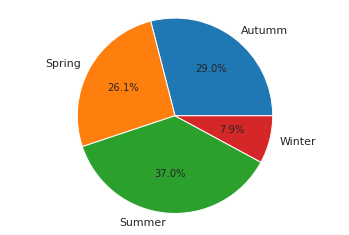

In [ ]:
fig1, ax1 = plt.subplots()
ax1.pie(dataset.groupby('Seasons').sum()['Rented Bike Count'], 
        labels=labels, autopct='%1.1f%%', colors=sns.color_palette("tab10"))
ax1.axis('equal')
plt.show()

No verão ocorre a maior prevalência das locações. Em seguida temos o outono e a primavera (com pouca diferença entre si) e o inverno.

### Quantidade média de bicicletas alugadas em feriados / dias úteis

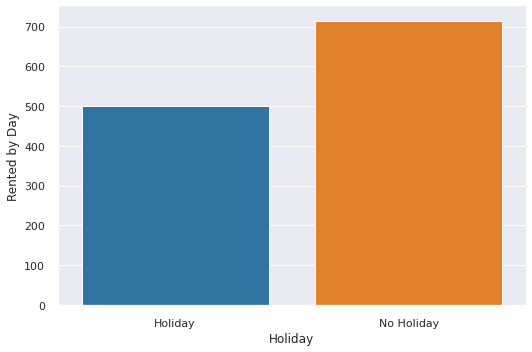

In [ ]:
labels = ['Holiday', 'No Holiday']
holiday = pd.DataFrame({'Holiday': labels, 
                       'Rented Bicycles': dataset.groupby('Holiday').sum()['Rented Bike Count'],
                       'Num Days': dataset.groupby('Holiday').count()['Rented Bike Count']})

holiday['Rented by Day'] = holiday['Rented Bicycles'] / holiday['Num Days']

sns.catplot(x='Holiday', y='Rented by Day', kind='bar', data=holiday, height=5, 
            aspect=1.5, ci=None, palette=sns.color_palette("tab10"))

Observa-se que há mais locações (em média) em dias úteis, confirmando a hipótese da utilização de bicicletas para locomoção até o trabalho.

## Criação de Variáveis

In [ ]:
# extracao do ano
dataset['Year'] = pd.DatetimeIndex(dataset['Date']).year

In [ ]:
# extracao do mes 
dataset['Month'] = pd.DatetimeIndex(dataset['Date']).day

In [ ]:
# extracao do dia
dataset['Day'] = pd.DatetimeIndex(dataset['Date']).month

In [ ]:
dataset.drop('Date', axis=1, inplace=True)

In [ ]:
dataset.head()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Year,Month,Day
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,12,1
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,12,1
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,12,1
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,12,1
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes,2017,12,1


## Pré-processamento de dados

In [ ]:
X = dataset.iloc[:, 1:].values
y = dataset.iloc[:, 0].values

In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer

# conversao das estacoes de texto para numero
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [9])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [ ]:
# tratamento dos feriados / dias uteis
le = LabelEncoder()
X[:, 13] = le.fit_transform(X[:, 13])

In [ ]:
# tratamento dos dias de funcionamento
X[:, 14] = le.fit_transform(X[:, 14])

## Divisão dos dados entre treino e teste

In [ ]:
# como os dados seguem uma serie temporal, dividiu-se o conjunto de treino
# no 70% inicial e o de teste no 30% final

SPLIT = 0.7

X_train = X[:int(X.shape[0] * SPLIT)]
X_test = X[int(X.shape[0] * SPLIT):]
y_train = y[:int(X.shape[0] * SPLIT)]
y_test = y[int(X.shape[0] * SPLIT):]

## Modelo (XGBoost) 

In [ ]:
# lista de parametros de otimizacao
#   n_estimators: quantidade de arvores
#   learning_rate: na pratica, quanto cada arvore contribuira para a aprendizagem do modelo
#   max_depth: profundidade maxima das arvores (ajuda a evitar overfitting)
#   subsample: tamanho da amostra que cada arvore ira considerar (contribui para um modelo mais versatil e diverso)

hyperparameter_space = {'n_estimators': [100, 120, 140, 170, 200],
                        'learning_rate': [0.01, 0.03, 0.05, 0.07, 0.1],
                        'max_depth':[4,5,6,7,8], 
                        'subsample':[0.25, 0.5, 0.75, 1]}

from xgboost import XGBRegressor
xgb_mod = XGBRegressor()


# utilizacao de pesquisa randomica para a busca do melhor modelo
#   n_iter: quantidade de modelos a serem testados
#   scoring: metrica de avaliacao
#   random_state: fixado para tornar os resultados reproduziveis
#   n_jobs: nucleos para processamento paralelo (-1 utilza o maximo disponivel)
#   cv (cross validation): util para detectar a capacidade de generalicao do modelo
#   return_train_score: retorna o score do treinamento

from sklearn.model_selection import RandomizedSearchCV
rs = RandomizedSearchCV(xgb_mod, param_distributions=hyperparameter_space,
                        n_iter=100, scoring="neg_mean_absolute_error", random_state=0,
                        n_jobs=-1, cv=5, return_train_score=True)

rs.fit(X_train, y_train)

[11:16:38] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_state=0, reg_alpha=...
                                          seed=None, silent=None, subsample=1,
                                          verbosity=1),
                   iid='deprecated', n_iter=100, n_jo

In [ ]:
rs.best_params_

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100, 'subsample': 1}

In [ ]:
rs.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=4, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

## Predição nos dados de treino

In [ ]:
# verifica os resultados da metrica de otimizacao dos modelos treinados com base nos dados de treino
cvres = rs.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(np.sqrt(-mean_score), params)

14.988483757525206 {'subsample': 0.75, 'n_estimators': 140, 'max_depth': 8, 'learning_rate': 0.01}
13.46906165015469 {'subsample': 0.75, 'n_estimators': 170, 'max_depth': 6, 'learning_rate': 0.05}
13.652497172192108 {'subsample': 1, 'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.05}
13.8537462151838 {'subsample': 0.5, 'n_estimators': 120, 'max_depth': 6, 'learning_rate': 0.1}
13.82470738846197 {'subsample': 0.5, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.1}
15.05163994676593 {'subsample': 1, 'n_estimators': 170, 'max_depth': 4, 'learning_rate': 0.01}
13.938442251268064 {'subsample': 0.25, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.07}
13.867377656155787 {'subsample': 0.5, 'n_estimators': 140, 'max_depth': 8, 'learning_rate': 0.1}
13.638793435251129 {'subsample': 1, 'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.03}
13.551965054337645 {'subsample': 0.5, 'n_estimators': 170, 'max_depth': 6, 'learning_rate': 0.03}
13.545795338068457 {'subsample'

Como o esperado, as predições nos dados de treino estão bem próximas da realidade.

## Predição nos dados de teste

In [ ]:
final_model = rs.best_estimator_
y_pred = final_model.predict(X_test)

## Performance do modelo nos dados de teste

### Erro Médio Absoluto

In [ ]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, y_pred)
print(mae)

262.97361700357004


### Erro Quadrático Médio

In [ ]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(rmse)

374.4458808966614


Grande diferença do erro médio absoluto entre os dados de treino e teste.

Aparentemente o modelo está apresentando overfitting.

Visando solucionar isso tentou-se modelos mais simples (regressão linear e SVR) mas, após testes, apresentaram resultados piores.

Outra abordagem é o aumento do volume de dados (o dataset atual possui 8760 registros).

Observo que, ao remover variáveis (precipitação e queda de neve) que possuem pouca relação com os demais atributos, o modelo apresentou leve piora.

Outro ponto interessante é que, com a remoção de outliers, o modelo piorou. Creio que alguns desses registros ajudam o modelo a abstrair melhor.

## Impacto das variáveis no modelo

In [ ]:
#sorted_idx = final_model.feature_importances_.argsort()
#plt.barh(boston.feature_names[sorted_idx], 
#final_model.feature_importances_[sorted_idx]
#feature_importance = feature_importance.sort_values('importance', ascending=False)

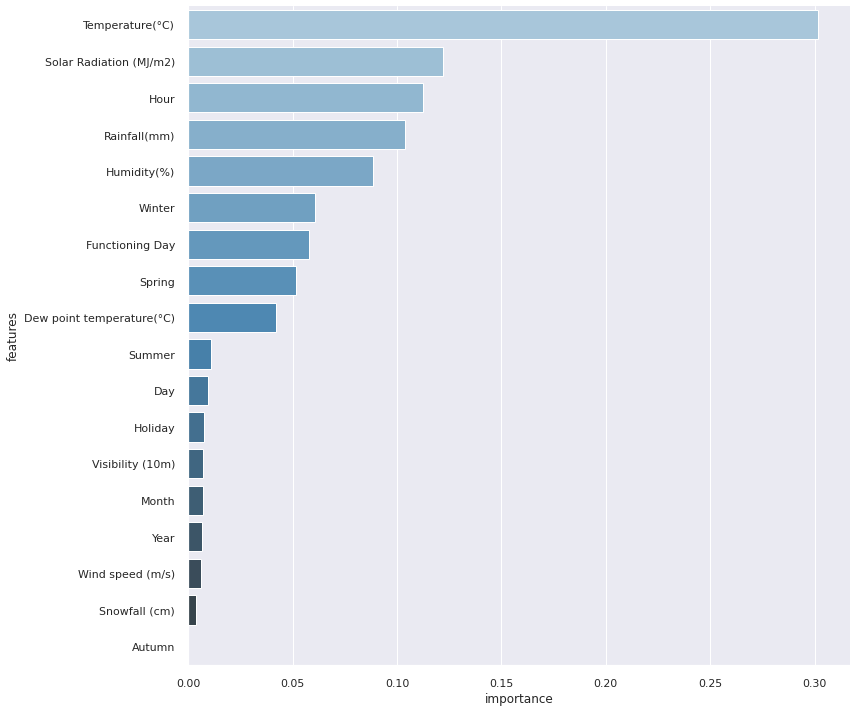

In [ ]:
features = ['Autumn', 'Spring','Summer','Winter', 'Hour', 'Temperature(°C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)',
       'Holiday', 'Functioning Day', 'Year', 'Month', 'Day']

feature_importance = pd.DataFrame({'features': features, 
                                   'importance':final_model.feature_importances_})

feature_importance = feature_importance.sort_values('importance', ascending=False)

sns.catplot(x='importance', y='features', kind='bar', data=feature_importance, height=10, 
            aspect=1.2,  palette='Blues_d', ci=None)

O modelo considera a temperatura a principal variável para predição. Radiação solar, hora e precipitação também são relevantes, o que realmente faz sentido pois estão entre os pricipais fatores a serem considerados na prática de atividades ao ar livre.

## Realizando uma predição

**Valores de entrada:**

1. Estação: outono
1. Hora: 7:00
1. Temperatura (° C): 5
1. Umidade (%): 20
1. Velocidade do vento (m / s): 0.3
1. Visibilidade (m): 1900
1. Temperatura do ponto de orvalho (° C): -5
1. Radiação solar (MJ / m2): 0.2
1. Precipitação (mm): 0
1. Queda de neve (cm): 0
1. Feriado: não
1. Dia de funcionamento: sim
1. Ano: 2018
1. Mes: novembro
1. Dia: 5



In [ ]:
pred = [1,0,0,0,7,5,20,0.3,1900,-5,0.2,0,0,1,1,2018,11,5]
print(final_model.predict([pred]))

[547.764]
